Ses tanıma



In [ ]:
import soundfile
soundfile.info("speech recognition_sr_1_example_sound.wav")

speech recognition_sr_1_example_sound.wav
samplerate: 22050 Hz
channels: 1
duration: 4.896 s
format: WAV (Microsoft) [WAV]
subtype: Signed 16 bit PCM [PCM_16]

In [ ]:
import librosa
import librosa.display

signal, sampling_rate=librosa.load("speech recognition_sr_1_example_sound.wav",sr=None)

In [ ]:
signal
signal.shape

(107957,)

In [ ]:
from IPython import display
display.Audio(signal, rate=sampling_rate)

In [ ]:
import sys
import numpy as np
np.set_printoptions(threshold=np.inf)

print(signal)
print(signal.shape)

In [ ]:
print(sampling_rate)
#ör oran
print(107957 / sampling_rate)

22050
4.8960090702947845


<Figure size 432x288 with 0 Axes>

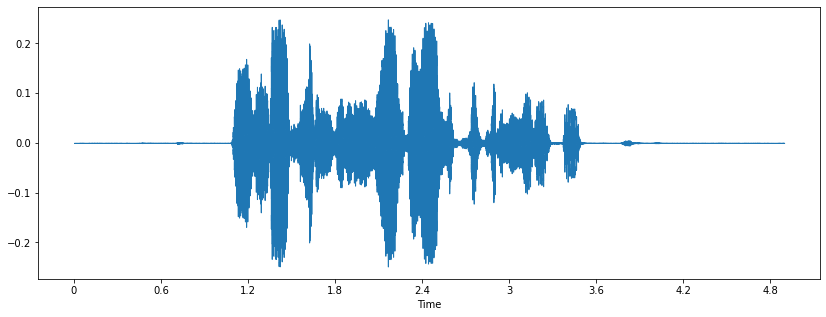

In [ ]:
#okunan veri çizimi
import matplotlib.pyplot as plt
import librosa.display

plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveshow(y=signal, sr=sampling_rate)

Öznitelikler:
STFT yöntemi ile sinyali işle, kolay okunabilen bizim istediğimiz formata dönüştür.
(görsel)

Kullanılan Öznitelikler:
Spectrogram
Mel-spectrogram
Chromagram



In [ ]:
import warnings
warnings.filterwarnings("ignore")
plt.ioff()

import numpy as np

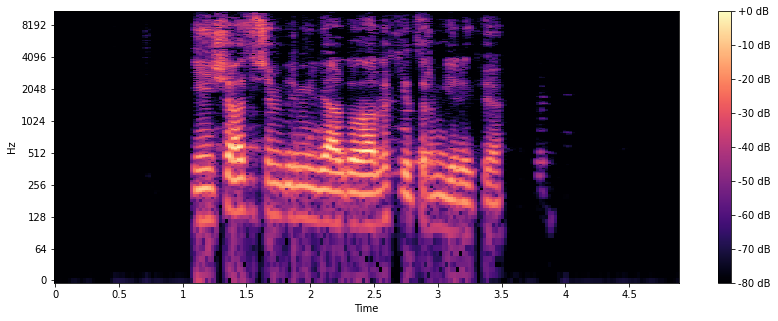

In [ ]:
spec = np.abs(librosa.stft(signal))
spec = librosa.amplitude_to_db(spec, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(spec, sr=sampling_rate, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

**Mel-spectrogram
düşük frekanslı sesleri daha iyi duyarız.
mel ölçekli spectrogram.

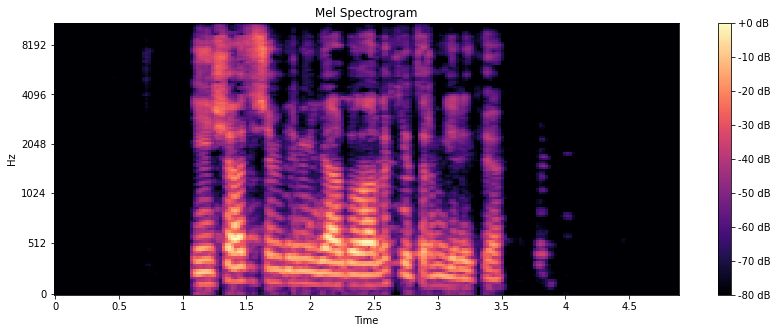

In [ ]:
mel_spect = librosa.feature.melspectrogram(y=signal, sr=sampling_rate)
mel_spect = librosa.power_to_db(mel_spect, ref=np.max)

plt.figure(figsize=(14, 5))
librosa.display.specshow(mel_spect, y_axis='mel', x_axis='time');
plt.title('Mel Spectrogram');
plt.colorbar(format='%+2.0f dB');

Chromagram
ses perde sınıflandırma, fazla kullanılmaz.

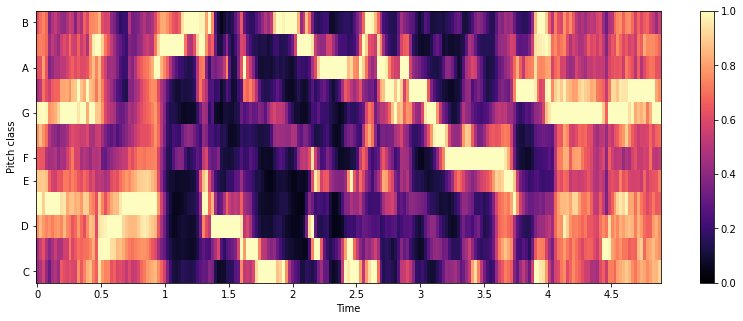

In [ ]:
C = librosa.feature.chroma_cqt(y=signal, sr=sampling_rate, bins_per_octave=36)

plt.figure(figsize=(14,5))
librosa.display.specshow(C, sr=sampling_rate, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
plt.colorbar()

** Mel-Frequency Cepstral Coefficients

In [ ]:
#veri setleri : 1. openslr librispeech (https://www.openslr.org/) 2. common voice (https://commonvoice.mozilla.org/en/datasets)

Veri Çoğaltma
Bilgisayarlı görü (computer vision) / Doğal dil işleme (natural language processing) / Konuşma Tanıma (Speech Recognition)

#speech augment metodu ile konuşma tanımada veri artırılır.
sinyali melspectrograma çevirir ve keserek kayıtta onları ekliyor.


In [ ]:
#Kendi sesim ile deneme 1

#2.PART
#SESİN KADIN VEYA ERKEK OLDUĞUNU AYIRIMI, sınıflandırma problemi
#veri setini uygun olan MB Türünden indirdik.

Derin Öğrenme Mimarisi

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
import torch.nn as nn
from torch.optim import lr_scheduler
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader

import time
import os
import copy
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

**Veri kümesinin oluşturulması**
-df.dropna(subseu=['gender']) şeklinde yazılan kısım gender kısmındaki null değerler haricini alacaktır. 

In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
os.environ['KAGGLE_CONFIG_DIR']= "/content/drive/MyDrive/Colab_Notebooks/cv-corpus-12.0-delta-2022-12-07.zip"
!ls

 cv-corpus-12.0-delta-2022-12-07.zip
 drive
 sample_data
'speech recognition_sr_1_example_sound.wav'


In [79]:
!unzip \*.zip && rm *.zip
#import zipfile

#zf = zipfile.ZipFile("/content/cv-corpus-12.0-delta-2022-12-07.zip",'w', compression=zipfile.ZIP_DEFLATED)
#zf.write("okunan_veri.txt")
#zf.close()

Archive:  cv-corpus-12.0-delta-2022-12-07.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of *.zip or
        *.zip.zip, and cannot find cv-corpus-12.0-delta-2022-12-07.zip.ZIP, period.

No zipfiles found.


In [ ]:
class VoiceDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_table(csv_path)
        self.df = df.dropna(subset=['gender'])
        
        self.wav_folder = "clips"
        self.classes = {'female': 0, 'male': 1}
        
        self.mel_limit = 256
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        wav_name = self.df.iloc[idx].path
        wav_path = os.path.join(self.wav_folder, wav_name)
        
        label = self.df.iloc[idx].gender
        label = self.classes[label]
        
        feature = self.load_sound(wav_path)
        
        return {'data': feature, 'label': label}
    
    def load_sound(self, path):
        signal, sampling_rate = librosa.load(path, sr=None)
        mel_spectrogram = librosa.feature.melspectrogram(signal, sampling_rate)
        mel_spectrogram = torch.from_numpy(mel_spectrogram)
        
        # padding & cutting
        length = mel_spectrogram.shape[1]
        n_mels = mel_spectrogram.shape[0]
        
        if length < self.mel_limit:
            pad_tensor = torch.zeros((n_mels, self.mel_limit-length))
            mel_spectrogram = torch.cat((mel_spectrogram, pad_tensor), 1)
        mel_spectrogram = mel_spectrogram[:, :self.mel_limit]

        return mel_spectrogram.unsqueeze(0)


train_dataset = VoiceDataset("/content/drive/MyDrive/Colab Notebooks/cv-corpus-12.0-delta-2022-12-07/tr/invalidated.tsv")
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = VoiceDataset("/content/drive/MyDrive/Colab Notebooks/cv-corpus-12.0-delta-2022-12-07/tr/validated.tsv")
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

dataloaders= {'train': train_dataloader,
             'val': val_dataloader}
data_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

sample = next(iter(train_dataloader))
print(sample['data'].shape)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Veri kümesinin incelenmesi**

In [ ]:
print("number of train sample: {}".format(len(train_dataset)))
print("number of val sample: {}".format(len(val_dataset)))

In [ ]:
#durations=[]
#for path in tqdm(train_dataset.df.path):
#  y, sr=librosa.load(os.path.join(train_dataset.wav_folder, path))
#  dur=librosa.get_duration(y,sr)
#  durations.append(dur)

#pd.DataFrame(durations).hist()

In [ ]:
print(train_dataset.df.gender.hist())

**Eğitim**

In [ ]:
device=torch.device("cuda:0")

In [ ]:
class VoiceModel(nn.Module):
  def __init__(self):
    super(VoiceModel, self).__init__()

    self.feature = nn.Sequential(
        nn.Conv2d(1,32,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2),

        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2),

        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3,stride=2),
    )

    self.classifier = nn.Sequential(
        nn.Linear(12,128),#shape  te çıkan sonuç 12 yerine gelecek
        nn.ReLU(),
        nn.Linear(128,2)
    )

    def forward(self, inputs):
      x=self.feature(inputs)
      x=torch.flatten(x,1)
      print(x.shape)  
      x=self.classifier(x)
      return x

model  =VoiceModel().to(device)

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
for epoch in range(25):
  print(f"Epoch : {epoch}")
  print("-"*10)

  for phase in ['train', 'val']:
    if phase =='train':
        model.train()
    else:
      model.eval()

    running_loss=0
    running_corrects=0

    for batch in tqdm(dataloaders[phase]):
      inputs = batch['data'].to(device)
      labels=batch['label'].to(device)

      optimizer.zero_grad()

      outputs=model(inputs)
      _, preds=torch.max(outputs , 1)
      loss  = criterion(outputs, labels)

      if phase =='train':
        loss.backward()
        optimizer.step()
      
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss=running_loss/data_sizes[phase]
    epoch_acc=running_corrects/data_sizes[phase]

    print('loss:{} | accuracy: {}'.format(epoch_loss, epoch_acc))

In [80]:
import torch
import torch.nn as nn
import numpy as np


def get_embedding(word):
    return np.random.rand(1, 300).astype(np.float32)


def get_word_list_english():
    return ["", "go", "came", "hello", "evening", "guys"]


words = ["merhaba", "arkadaşlar"]
embeddings = [get_embedding(w) for w in words]
embeddings = torch.tensor(embeddings)

encoder = nn.RNN(input_size=300, hidden_size=512)
decoder = nn.RNN(input_size=300, hidden_size=512)
classifier = nn.Linear(512, len(get_word_list_english()))

_, context = encoder(embeddings)

predicted_word_list = []
predicted_word = "<start_token>"
hn = context

for i in range(20):
    decoder_input = torch.tensor(get_embedding(predicted_word)).unsqueeze(0)
    outputs, hn = decoder(decoder_input, hn)

    outputs = classifier(outputs)
    probabilities = nn.Softmax(dim=2)(outputs)
 
    predicted_word_index = torch.argmax(probabilities)
    predicted_word = get_word_list_english()[predicted_word_index]
    predicted_word_list.append(predicted_word)


predicted_word_list = ["hello", "guyz"]

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import librosa
signal, sampling_rate = librosa.load("../sr_1/example_sound.wav", sr=None)
mel_spectrogram = librosa.feature.melspectrogram(signal, sampling_rate)

import librosa.display
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
librosa.display.specshow(librosa.power_to_db(mel_spectrogram, ref=np.max), y_axis='mel', x_axis='time');
plt.colorbar(format='%+2.0f dB');

In [ ]:
import torch
import torch.nn as nn
import numpy as np


def get_phoneme_list():
    return [" ","AA","AE","AH","AO","AW","AY","B","CH","D","DH","EH","ER","EY","F","G","HH","IH","IY","JH","K","L","M","N","NG","OW","OY","P","R","S","SH","T","TH","UH","UW","V","W","Y","Z","ZH"]


embeddings = torch.from_numpy(mel_spectrogram).T.unsqueeze(0)

acustic_model = nn.RNN(input_size=128, hidden_size=512)
classifier = nn.Linear(512, len(get_phoneme_list()))

outputs, context = acustic_model(embeddings)
outputs = classifier(outputs)
probabilities = nn.Softmax(dim=2)(outputs)
print(probabilities.shape)

In [ ]:
def get_vocab():
    return {"a": 0, "b": 1, "c": 2, "ç": 3, "d": 4, "e": 5, "f": 6, "g": 7, "ğ": 8, "h": 9, "ı": 10, "i": 11,
            "j": 12, "k": 13, "l": 14, "m":15, "n": 16, "o": 17, "ö": 18, "p": 19, "r":20, "s": 21, "ş": 22,
            "t": 23 ,"u": 24, "ü": 25, "v": 26, "y": 27, "z":28, ' ': 29, "1": 30}


def char_to_num(sentence):
    return torch.tensor([get_vocab()[i] for i in sentence]).unsqueeze(0)


target_sentence = "inşaat için 1 milyar dolarlık yatırım gerekiyor"
target = char_to_num(target_sentence)

T = 211                   # Input sequence length
C = 40                    # Number of classes
N = 1                     # Batch size
S = len(target_sentence)  # Target sequence length 

probabilities = probabilities.requires_grad_().transpose(0,1)


input_lengths = torch.tensor([T], dtype=torch.int)
target_lengths = torch.tensor([S], dtype=torch.int)
probabilities = probabilities

ctc_loss = nn.CTCLoss()
loss = ctc_loss(probabilities, target, input_lengths, target_lengths)
loss.backward()

print(loss)

Ön eğitimli modelleri indir

In [ ]:
!wget https://github.com/mozilla/DeepSpeech/releases/download/v0.9.3/deepspeech-0.9.3-models.pbmm -O deepspeech-0.9.3-models.pbmm
!wget https://github.com/mozilla/DeepSpeech/releases/download/v0.9.3/deepspeech-0.9.3-models.scorer -O deepspeech-0.9.3-models.scorer

In [ ]:
import deepspeech
model_file_path = "deepspeech-0.9.3-models.pbmm"
model = deepspeech.Model(model_file_path)
